## **Sección 1: Modelo Baseline, Support Vector Machine [SVM]**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import shap

c:\Users\56940\Code\XAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.1 Cargar Data**

In [2]:
ar_path = './Caracterizacion.xlsx'
ar_df = pd.read_excel(ar_path)

---

## **1.2 Train-Test Split**

In [3]:
scaler = StandardScaler()
X = ar_df.drop(columns=['clase', 'fecha_inicio','fecha_fin'])
y = ar_df['clase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

## **1.3 Modelo Simple y Directo**

In [4]:
model = SVC(kernel="linear", class_weight="balanced", random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.80      0.59        10
           1       0.89      0.65      0.76        26

    accuracy                           0.69        36
   macro avg       0.68      0.73      0.67        36
weighted avg       0.78      0.69      0.71        36



**Podemos ver que tenemos un F1 bastante mediocre para la clase 0, nos interesa el F-1 porque en el EDA pudimos ver que tenemos clases desbalanceadas**

---

## **1.4 Búsqueda en Grilla de Párametros**

In [5]:
param_grid = [
    {
        "kernel": ["rbf", "poly", "sigmoid"],
        "C": [1, 2, 3, 4, 5, 6 ,7 ,8 ,9, 10, 100 ],
        "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1, 10],
        "degree": [2, 3, 4, 5],
        "coef0": [0, 0.5, 1, 2],
        "class_weight": [None, "balanced"]
    }
]

svm = SVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 7392 candidates, totalling 36960 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'coef0': [0, 0.5, 1, 2], 'degree': [2, 3, 4, 5],
                          'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
                          'kernel': ['rbf', 'poly', 'sigmoid']}],
             scoring='f1', verbose=2)

In [6]:
print("Mejores parámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Mejores parámetros: {'C': 3, 'class_weight': None, 'coef0': 0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


**Esta es la mejor configuración que encontró la búsqueda en grilla de párametros:**

Mejores parámetros: {'C': 3, 'class_weight': None, 'coef0': 0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}

---

# **Sección 2: Evaluación del Modelo**

## **2.1 Classification Report**

---

In [7]:
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.72      1.00      0.84        26

    accuracy                           0.72        36
   macro avg       0.36      0.50      0.42        36
weighted avg       0.52      0.72      0.61        36



c:\Users\56940\Code\XAI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\56940\Code\XAI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\56940\Code\XAI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **2.2 Confusion Matrix**

Text(70.72222222222221, 0.5, 'True')

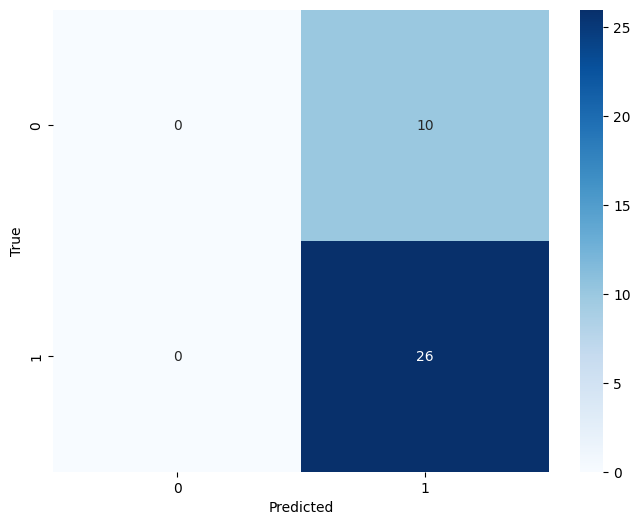

In [8]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

Cómo podemos ver el modelo baseline tiene un gran problema y es que no logra aprender a predecir la clase 0

---

# **Sección 3: Explicabilidad con Shap**

## **Sección 3: Modelo Pro: XgBoost**

# SHAP

In [10]:
# Verificar si el kernel es lineal
if best_model.kernel == 'linear':
    # Usar LinearExplainer para kernels lineales (más eficiente)
    explainer = shap.LinearExplainer(
        best_model,
        shap.sample(X_train_scaled, 100)  # Muestra representativa
    )
    shap_values = explainer.shap_values(X_test_scaled)
else:
    # Crear función de predicción adaptada para KernelExplainer
    def svm_predict(X):
        return best_model.decision_function(X)
    
    # Usar KernelExplainer con función personalizada
    explainer = shap.KernelExplainer(
        svm_predict,
        shap.sample(X_train_scaled, 100)  # Muestra de fondo reducida
    )
    
    # Calcular SHAP values (solo para un subconjunto por rendimiento)
    shap_values = explainer.shap_values(X_test_scaled[:50])

100%|██████████| 36/36 [00:01<00:00, 35.16it/s]


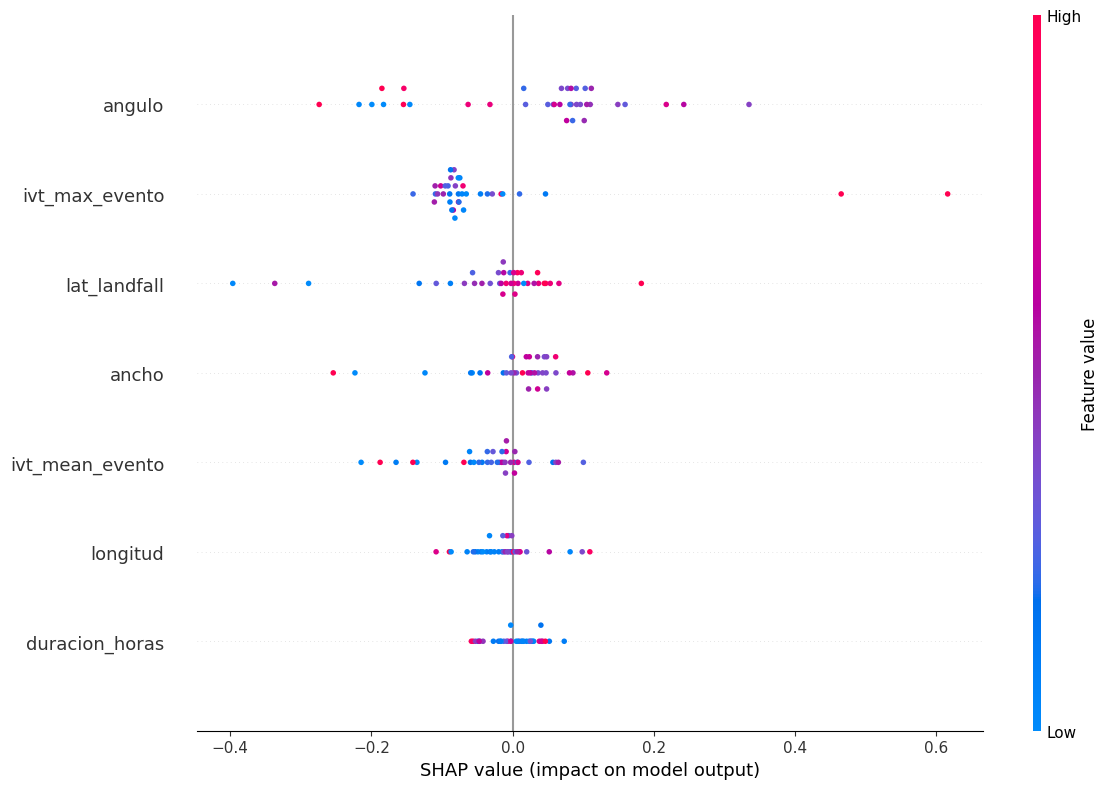

In [11]:
# Summary Plot (violín)
shap.summary_plot(
    shap_values, 
    features=X_test_scaled[:len(shap_values)],
    feature_names=X.columns,
    plot_size=(12, 8)
)

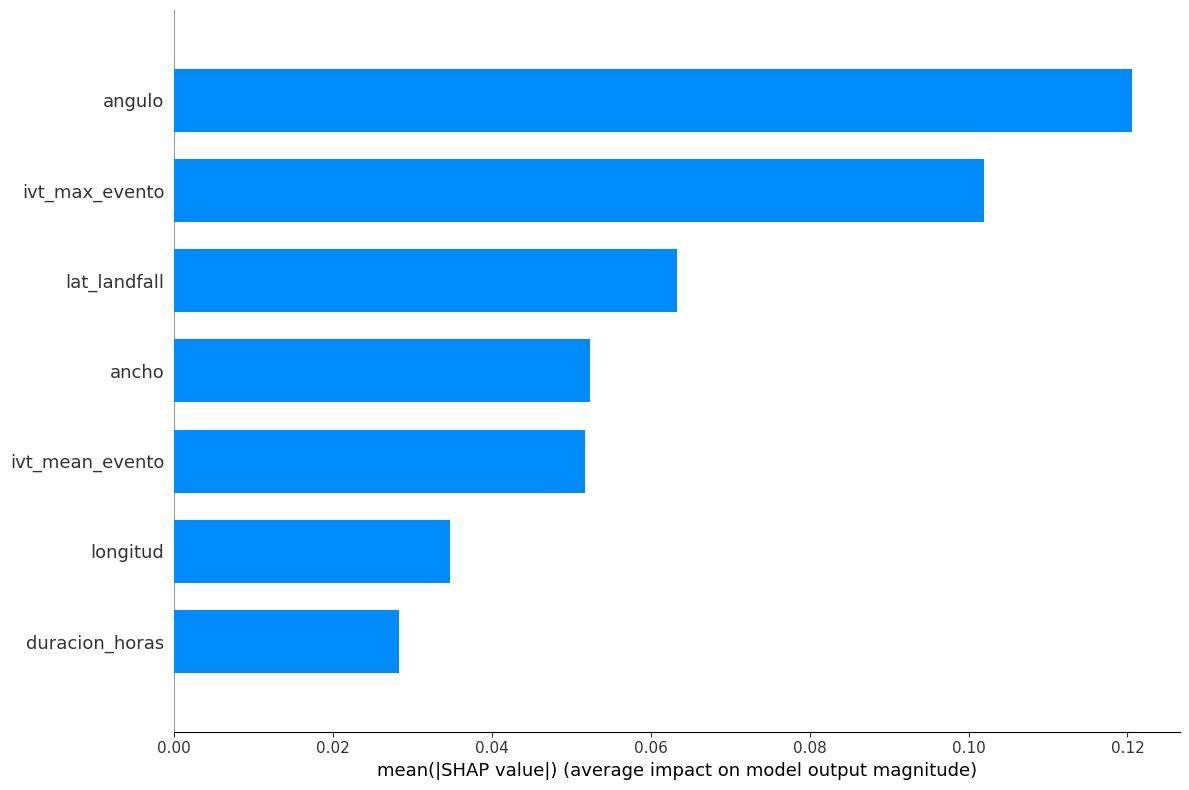

In [13]:
# Summary Plot de barras
shap.summary_plot(
    shap_values,
    features=X_test_scaled[:len(shap_values)],
    feature_names=X.columns,
    plot_type="bar",
    plot_size=(12, 8)
)

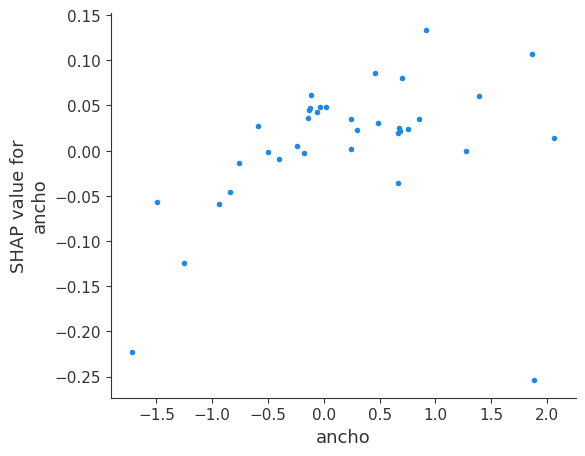

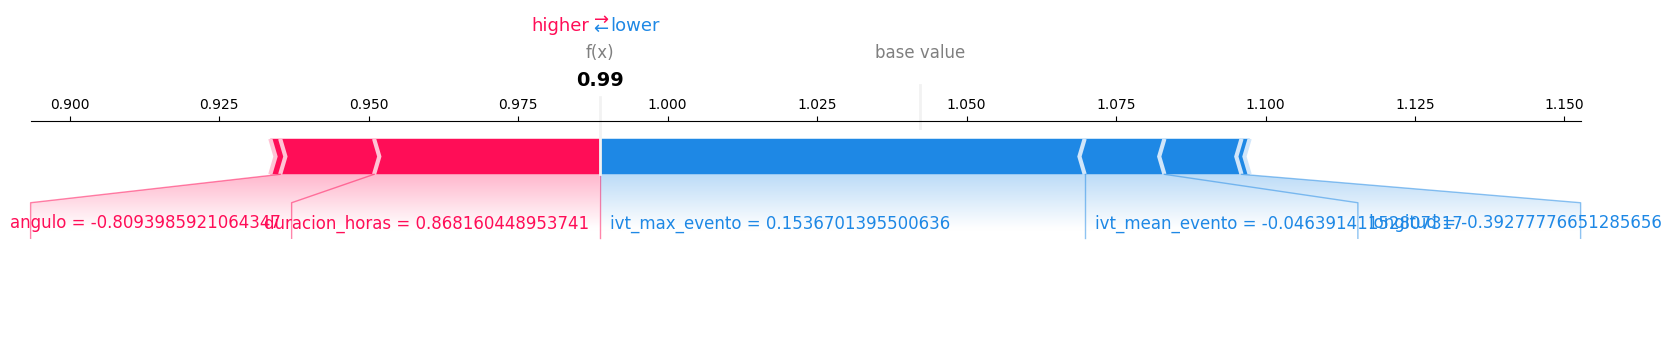

In [14]:
# Dependence Plot para "ancho"
try:
    shap.dependence_plot(
        "ancho", 
        shap_values,
        features=X_test_scaled[:len(shap_values)],
        feature_names=X.columns,
        interaction_index=None
    )
except IndexError:
    print("Característica 'ancho' no encontrada. Verifica el nombre en X.columns")

# Force Plot solo para primera instancia
shap.initjs()
shap.plots.force(
    explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values[0],
    features=X_test_scaled[0],
    feature_names=X.columns,
    matplotlib=True
)